In [0]:
import torch
import pdb
import torch.nn as nn
import math
from torch.autograd import Variable
from torch.autograd import Function
import time
from torch.distributions.relaxed_bernoulli import RelaxedBernoulli,LogitRelaxedBernoulli
import numpy as np


def Binarize(tensor,quant_mode='det'):
    if quant_mode=='det':
      tensor = tensor.sign()
      tensor[tensor==0] = 1
      return tensor
    else:
        return tensor.add_(1).div_(2).add_(torch.rand(tensor.size()).add(-0.5)).clamp_(0,1).round().mul_(2).add_(-1)

  
def sampling(mu,sig):
  x = Normal(mu,sig)
  p = 1 - x.cdf(0)
  return p


import torch.nn._functions as tnnf


    
class PBinarizeLinear(nn.Linear):

    def __init__(self, *kargs, **kwargs):
        super(PBinarizeLinear, self).__init__(*kargs, **kwargs)

    def forward(self, input):      
      
        if not hasattr(self.weight,'org'):
            self.weight.org=self.weight.data.clone()  
            
        self.weight.data=Binarize(self.weight.org)
        theta = torch.tanh(self.weight)

        if input.size(1) != 784:
          mu = nn.functional.linear(input,theta)
          left = input**2 - (1- input**2)
          right = theta**2 - (1-theta**2)
          sigma = 1 - nn.functional.linear(left,right)
        else:
          input = torch.tanh(input)
          mu = nn.functional.linear(input,theta)       
          sigma = nn.functional.linear(input**2,1-(theta**2))
        
        m = mu.mean(0,True)
        
        v = sigma.var(0,True)
     
        mu = 0.5*(mu-m)/((v+(0.0001)).sqrt()+0.5)
        sigma = 0.5**2*sigma/(v+0.0001)

        out1 = sampling(mu,sigma)

        if self.out_features==10:
          return mu
        else:
          return out1



class PBinarizeConv2d(nn.Conv2d):

    def __init__(self, *kargs, **kwargs):
        super(PBinarizeConv2d, self).__init__(*kargs, **kwargs)
        

    def forward(self, input):
        if not hasattr(self.weight,'org'):
            self.weight.org=self.weight.data.clone()  
            
        self.weight.data=Binarize(self.weight.org)
        theta = torch.tanh(self.weight)
        
        if input.size(1) != 1:
          mu = nn.functional.conv2d(input, theta, None, self.stride,
                                   self.padding, self.dilation, self.groups)
          left = input**2 - (1- input**2)
          right = theta**2 - (1-theta**2)
          sigma = 1 - nn.functional.conv2d(left, right, None, self.stride,
                                   self.padding, self.dilation, self.groups)
        else:
          input = torch.tanh(input)
          mu = nn.functional.conv2d(input, theta, None, self.stride,
                                   self.padding, self.dilation, self.groups)
          sigma = nn.functional.conv2d(input**2, 1-(theta**2), None, self.stride,
                                   self.padding, self.dilation, self.groups)

        m = mu.mean((0,2,3),True)

        v = sigma.var((0,2,3)).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
     
        mu = 0.5*(mu-m)/((v+(0.0001)).sqrt()+0.5)
        sigma = 0.5**2*sigma/(v+0.0001)
     
        mu = nn.functional.max_pool2d(mu, 2, 2,0, 1, False,False)
        sigma = nn.functional.max_pool2d(sigma, 2, 2,0, 1, False,False)
                            
        
        out1 = sampling(mu,sigma)
   
        return out1

    



In [0]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from tqdm import tqdm
from torch.distributions.normal import Normal
from torch.distributions.relaxed_bernoulli import RelaxedBernoulli
from torch.distributions.relaxed_categorical import RelaxedOneHotCategorical

from torch.distributions.categorical import Categorical

torch.manual_seed(1)
torch.cuda.manual_seed(1)


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=128, shuffle=True)





# 32C3 - MP2 - 64C3 - Mp2 - 512FC - SM10c
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = PBinarizeConv2d(1, 32, kernel_size=3)
        self.mp1= nn.MaxPool2d(kernel_size=2, stride=2)
      
        self.conv2 = PBinarizeConv2d(32, 64, kernel_size=3)
        self.mp2= nn.MaxPool2d(kernel_size=2, stride=2)
     
        self.fc1 = PBinarizeLinear(1600, 512)
   
        self.fc2 = PBinarizeLinear(512, 10)


    # 32C3 - MP2 - 64C3 - Mp2 - 512FC - SM10c
  
    def forward(self, x):

        
      x = self.conv1(x)
      x = self.conv2(x)

      x = x.view(x.size(0), -1)

      x = self.fc1(x)

      x = self.fc2(x)


      return x
  

model = Net()

print(model)

torch.cuda.device('cuda')
model.cuda()



criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    
    losses = []
    trainloader = tqdm(train_loader)
    
    for batch_idx, (data, target) in enumerate(trainloader):
 
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

#         if epoch%40==0:
#             optimizer.param_groups[0]['lr']=optimizer.param_groups[0]['lr']*0.1


        loss.backward()
    
        for p in list(model.parameters()):
            if hasattr(p,'org'):
                p.data.copy_(p.org)
        optimizer.step()
        
        for p in list(model.parameters()):
            if hasattr(p,'org'):
                p.org.copy_(p.data.clamp_(-0.9,0.9))
    
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)


loss_history = []
acc_history = []

def test():
    model.eval()
    test_loss = 0
    correct = 0
    testloader = tqdm(test_loader)
    for data, target in testloader:
        data, target = data.cuda(), target.cuda()
        with torch.no_grad():
          data = Variable(data)
        target = Variable(target)
        output = model(data)
        test_loss += criterion(output, target).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
        

        loss = test_loss / len(test_loader.dataset)
        acc = (100. *correct / len(test_loader.dataset)).numpy()

        testloader.set_postfix(loss= loss,acc=str(acc)+'%')
    
    test_loss /= len(test_loader.dataset)
    total_acc = correct.item()/len(test_loader.dataset)
    loss_history.append(test_loss)
    acc_history.append(total_acc)
    




Net(
  (conv1): PBinarizeConv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): PBinarizeConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): PBinarizeLinear(in_features=1600, out_features=512, bias=True)
  (fc2): PBinarizeLinear(in_features=512, out_features=10, bias=True)
)


In [0]:
%%%time
for epoch in range(50):
    train(epoch)
    test()

100%|██████████| 79/79 [00:02<00:00, 36.15it/s, acc=96%, loss=0.000752]

CPU times: user 18min 19s, sys: 2min 49s, total: 21min 8s
Wall time: 23min 15s


[0.0010023402515798806, 0.0007946641650050879, 0.0007294871553778649, 0.0005287206685170531, 0.000708057640120387, 0.0006744334034621715, 0.0006205168716609478, 0.000590706323646009, 0.0005962012475356459, 0.0005006236996501684, 0.0005776476407423615, 0.0005335211029276252, 0.0005169255804270506, 0.0005391250057145954, 0.0005501289052888751, 0.0005371218118816614, 0.0005305530102923513, 0.0005118349546566605, 0.000454313025996089, 0.00048783971481025217, 0.00048447325527667997, 0.0005330602250993252, 0.0004999117178842425, 0.0005435959048569202, 0.000491478518024087, 0.0005507441405206919, 0.0004718584535643458, 0.00045715297348797323, 0.0004955769672989846, 0.0004435283789411187, 0.0005002777488902211, 0.0005505225706845521, 0.0004678412524983287, 0.0004944756664335728, 0.00044683583360165355, 0.0004781138237565756, 0.0004986934699118137, 0.0004286873836070299, 0.00046533534545451405, 0.00046397409178316595, 0.0005144781727343798, 0.00045583420228213073, 0.0004428283194079995, 0.00050

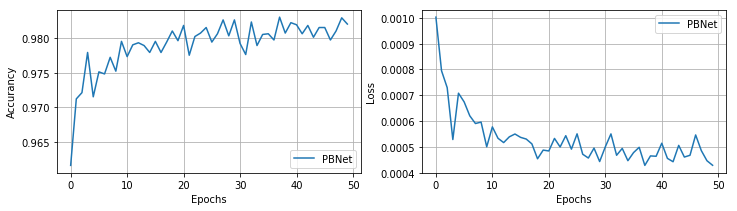

In [0]:
#1

print(loss_history)

print(acc_history)


import numpy as np
import matplotlib.pyplot as plt

f = plt.figure(figsize=(12,3))
ax = f.add_subplot(121)
ax.plot(acc_history,label='PBNet')
ax.grid()
ax.set_ylabel('Accurancy')
ax.set_xlabel('Epochs')
ax.legend(loc='lower right')

ax2 = f.add_subplot(122)
ax2.plot(loss_history,label='PBNet')
ax2.grid()
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.legend(loc='upper right')